In [1]:
# ===========================================
# Molecular Descriptors Calculation using RDKit
# ===========================================

from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
from tqdm import tqdm

# === 1. Load your Excel file ===
input_file = "C:/Users/gkjhe/Downloads/700 compunds of pesticides/pubchem_rest_smiles.xlsx"  # <-- your uploaded file
df = pd.read_excel(input_file)

# 🔹 Change this to the column name that contains SMILES
smiles_column = "smiles"  # <-- update if different

# === 2. Prepare descriptor names ===
descriptor_names = [desc_name for desc_name, _ in Descriptors._descList]

# === 3. Compute descriptors ===
descriptor_data = []

print("Calculating molecular descriptors...")

for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    smi = str(row[smiles_column]).strip()
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"Invalid SMILES: {smi}")
        continue

    values = {}
    for name, func in Descriptors._descList:
        try:
            values[name] = func(mol)
        except Exception:
            values[name] = None

    values["smiles"] = smi
    descriptor_data.append(values)

# === 4. Convert to DataFrame ===
desc_df = pd.DataFrame(descriptor_data)

# === 5. Save to Excel ===
output_file = "molecular_DEScriptors.xlsx"
desc_df.to_excel(output_file, index=False)

print(f"\n✅ Done! Descriptors saved to: {output_file}")


Calculating molecular descriptors...


100%|████████████████████████████████████████████████████████████████████████████████| 743/743 [00:09<00:00, 80.87it/s]



✅ Done! Descriptors saved to: molecular_DEScriptors.xlsx


In [2]:
import pandas as pd
import numpy as np

# Load Excel file
df = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/molecular_DEScriptors.xlsx")

# Keep only numeric columns
df_numeric = df.select_dtypes(include=['number'])

# Remove zero-variance features
zero_var_features = [col for col in df_numeric.columns if df_numeric[col].nunique() <= 1]
df_numeric = df_numeric.drop(columns=zero_var_features)
print(f"Removed {len(zero_var_features)} zero-variance features.")

# Compute absolute correlation matrix
corr_matrix = df_numeric.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify highly correlated features (|r| > 0.95)
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.95)]
print(f"Removed {len(to_drop)} highly correlated features.")

# Drop them from dataset
df_reduced = df_numeric.drop(columns=to_drop)

# Save to a new Excel file (choose your own filename)
output_path = "molecular_DEScriptors_filtered.xlsx"
df_reduced.to_excel(output_path, index=False)

print(f"\nFiltered dataset saved as: {output_path}")
print(f"Final dataset shape: {df_reduced.shape}")


Removed 16 zero-variance features.
Removed 30 highly correlated features.

Filtered dataset saved as: molecular_DEScriptors_filtered.xlsx
Final dataset shape: (745, 171)


In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

# Load your dataset
X = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/Molecular_Descriptors_Filtered.xlsx")  # descriptor features
y = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/experimental value .xlsx")       # experimental values
     # experimental values
y = y.values.ravel()  # flatten if single column

# Initialize the model

model = RandomForestRegressor(n_estimators=100, random_state=42)

# Step 3: RFE for top 20 descriptors
model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=model, n_features_to_select=20)
rfe.fit(X, y)

# Print top 20 descriptors
top20_descriptors = X.columns[rfe.support_]
print("Top 20 descriptors selected by RFE:")
for i, feature in enumerate(top20_descriptors, start=1):
    print(f"{i}. {feature}")

# Create a DataFrame with feature names and their ranking
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_
})

# Mark top 20 features
feature_ranking['Top20'] = feature_ranking['Ranking'].apply(lambda x: 'Yes' if x == 1 else 'No')

# Save to a single CSV
feature_ranking.to_csv('descriptors_rfe.csv', index=False)
print("RFE results saved to 'descriptors_rfe.csv'.")


Top 20 descriptors selected by RFE:
1. qed
2. MolWt
3. MaxPartialCharge
4. MinPartialCharge
5. FpDensityMorgan1
6. BCUT2D_MWLOW
7. BCUT2D_CHGLO
8. BCUT2D_LOGPHI
9. BCUT2D_LOGPLOW
10. BCUT2D_MRHI
11. BCUT2D_MRLOW
12. AvgIpc
13. BertzCT
14. Chi3v
15. Kappa3
16. SMR_VSA1
17. SMR_VSA10
18. VSA_EState5
19. VSA_EState9
20. MolLogP
RFE results saved to 'descriptors_rfe.csv'.


Top 20 descriptors selected by RFE:
1. qed
2. MolWt
3. MaxPartialCharge
4. MinPartialCharge
5. FpDensityMorgan1
6. BCUT2D_MWLOW
7. BCUT2D_CHGLO
8. BCUT2D_LOGPHI
9. BCUT2D_LOGPLOW
10. BCUT2D_MRHI
11. BCUT2D_MRLOW
12. AvgIpc
13. BertzCT
14. Chi3v
15. Kappa3
16. SMR_VSA1
17. SMR_VSA10
18. VSA_EState5
19. VSA_EState9
20. MolLogP

Summary statistics:
              qed       MolWt  MaxPartialCharge  MinPartialCharge  \
count  745.000000  745.000000        745.000000        745.000000   
mean     0.605837  287.948176          0.291230         -0.396279   
std      0.175317  103.673905          0.114757          0.089553   
min      0.121511   42.041000         -0.018404         -0.511479   
25%      0.470197  216.620000          0.228190         -0.468577   
50%      0.601206  291.306000          0.311285         -0.405797   
75%      0.762996  360.347000          0.355470         -0.335388   
max      0.943451  593.673000          0.639308         -0.061033   

       FpDensityMorgan1  BCUT2

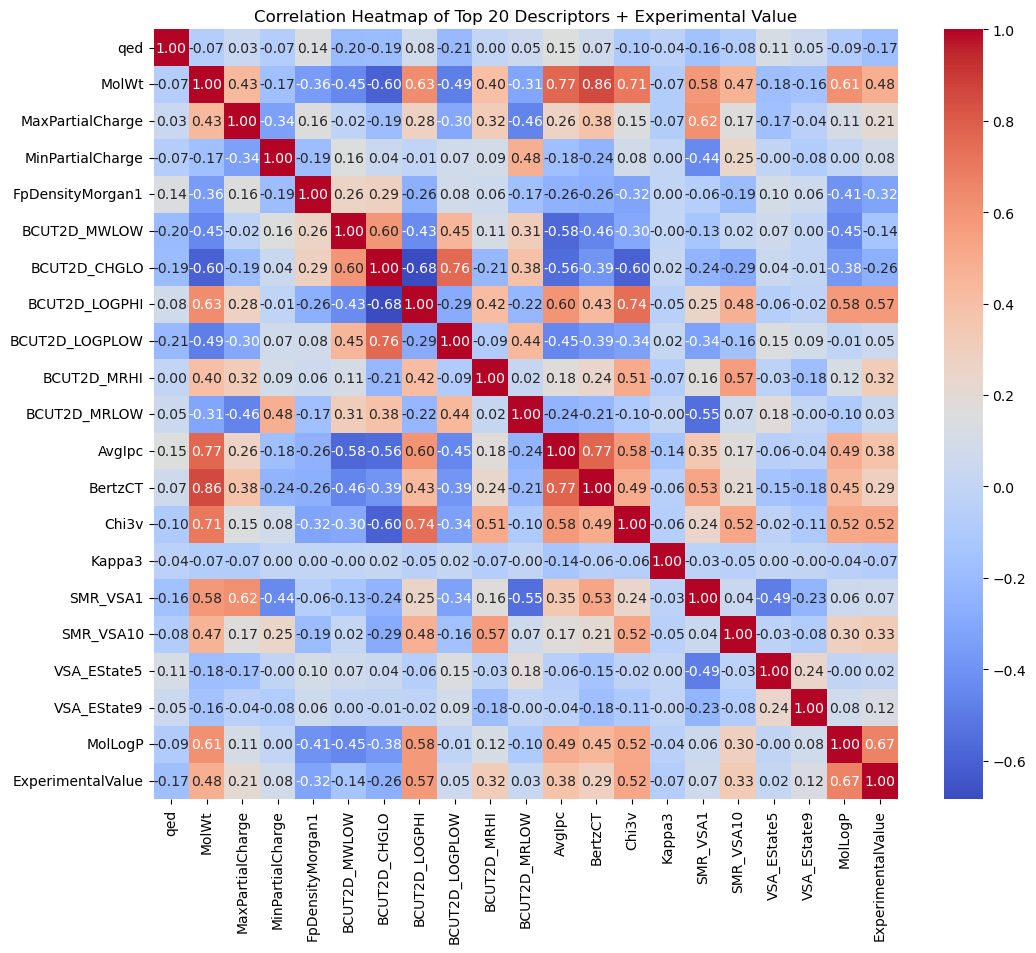

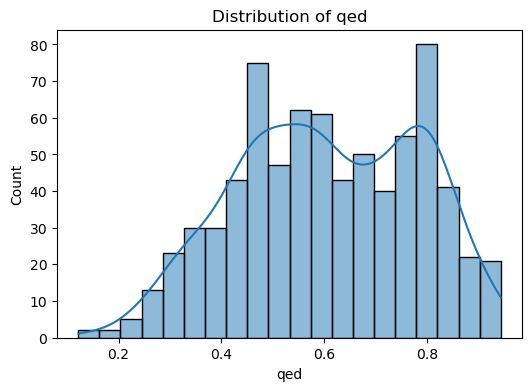

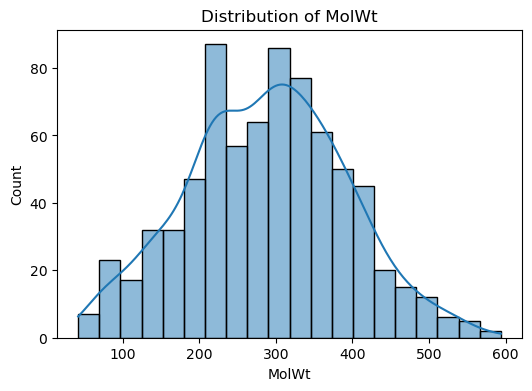

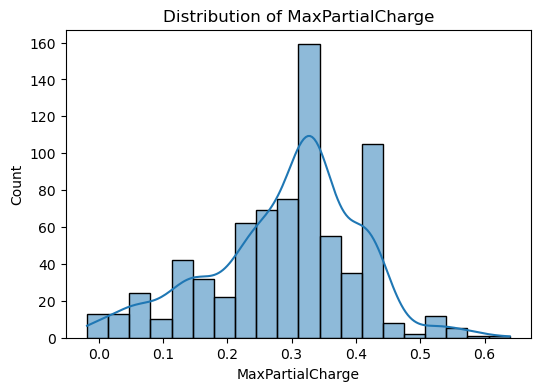

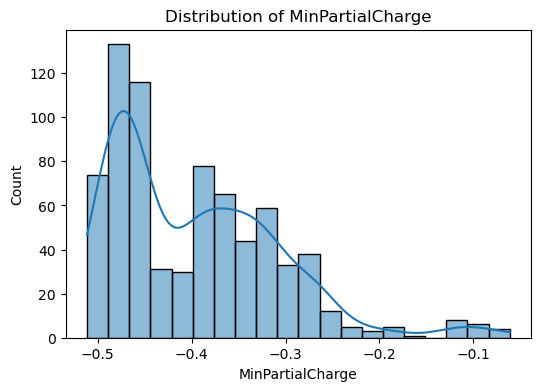

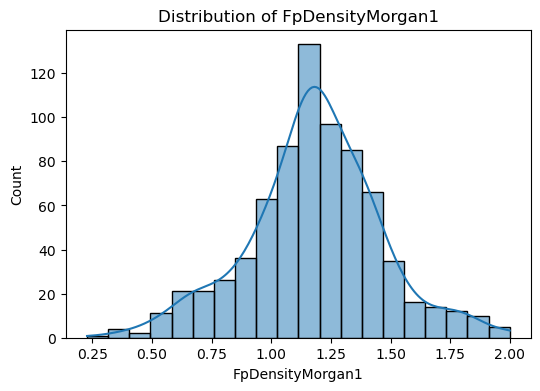

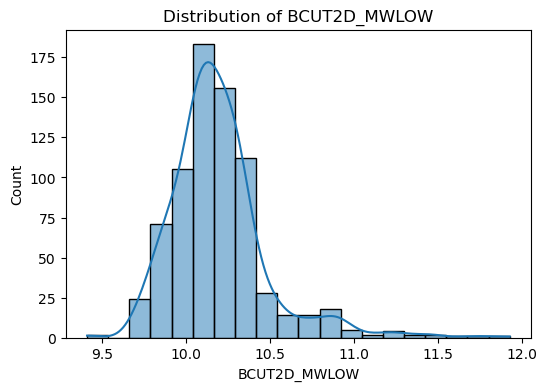

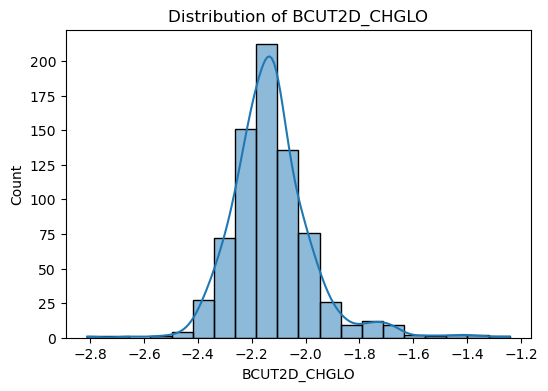

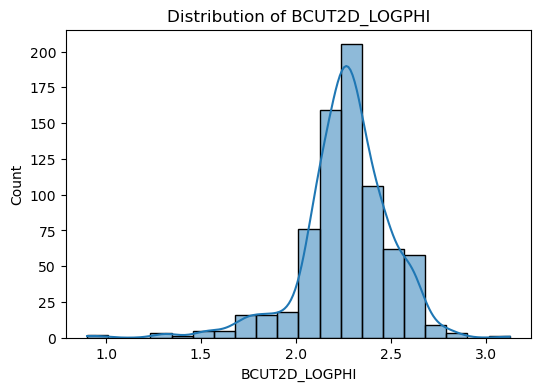

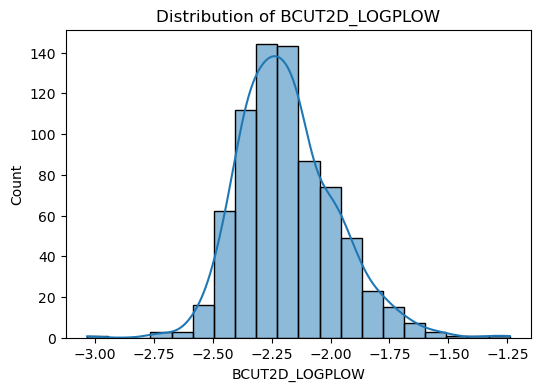

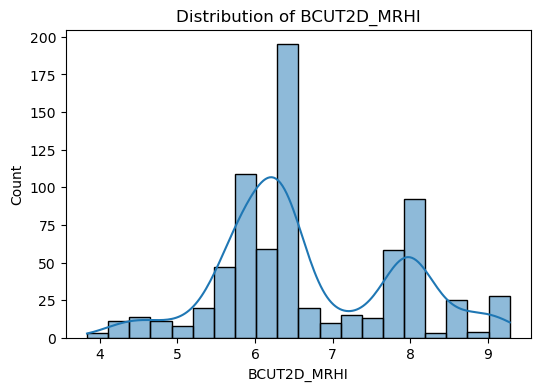

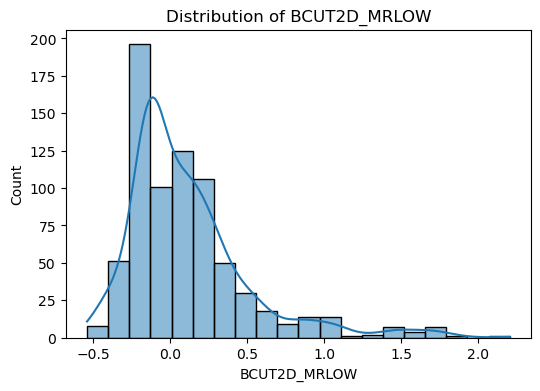

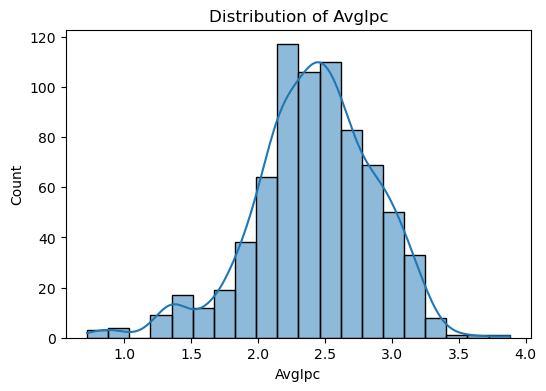

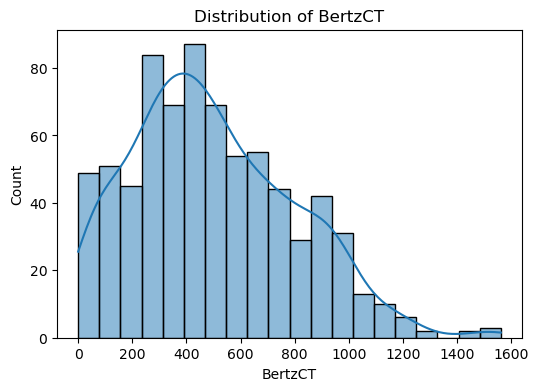

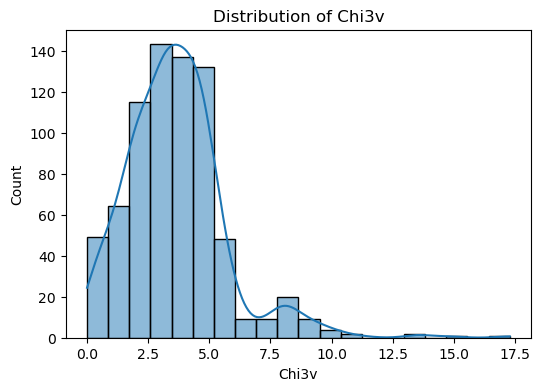

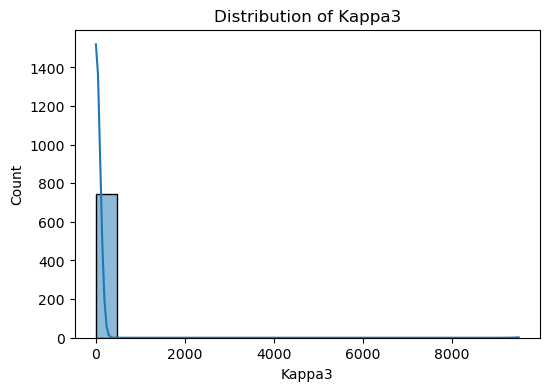

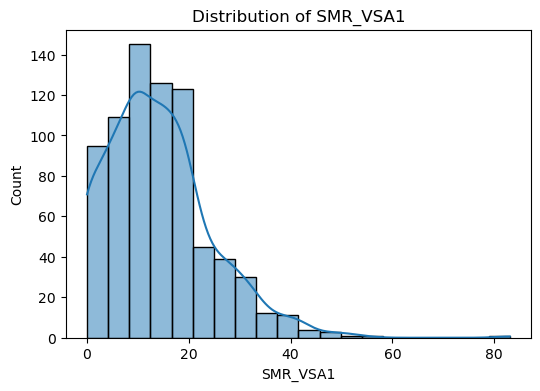

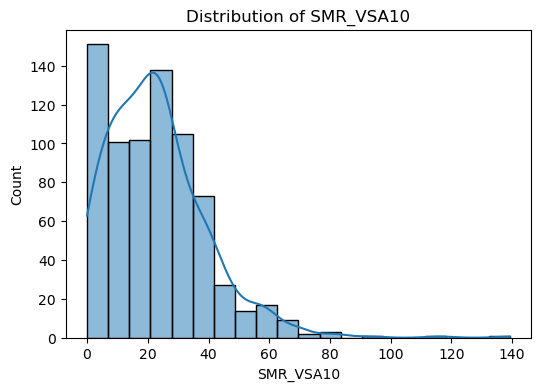

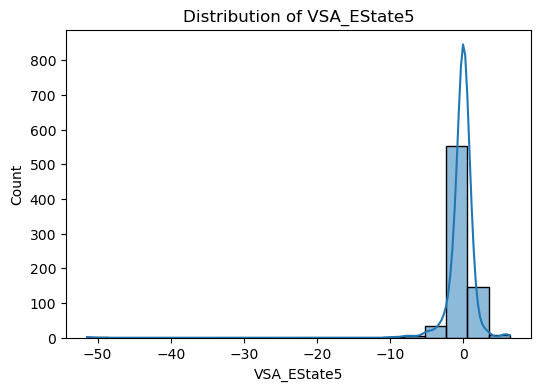

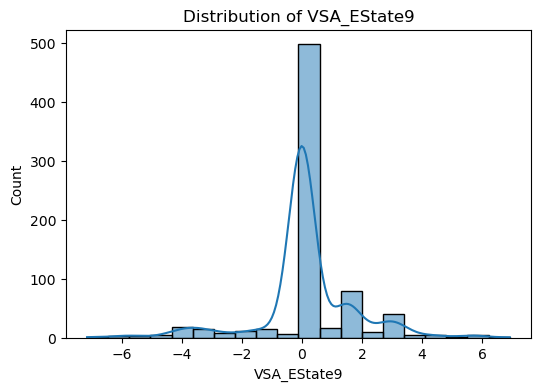

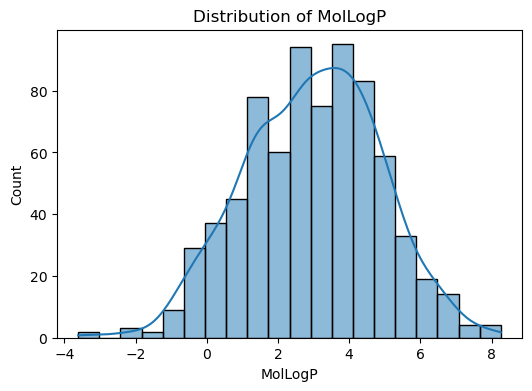

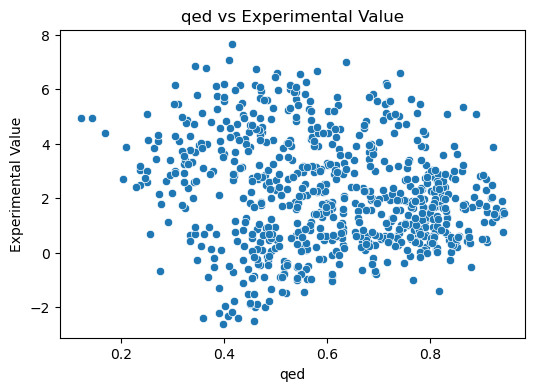

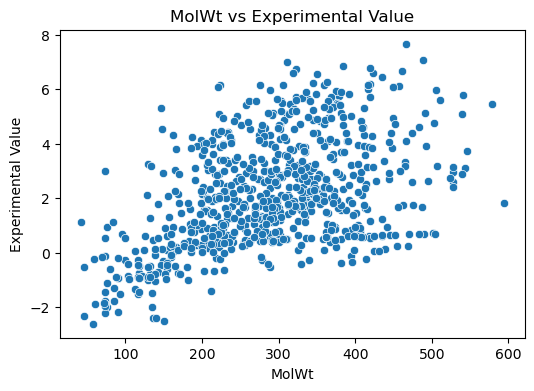

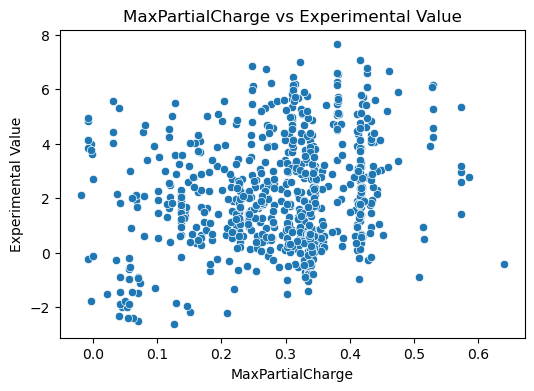

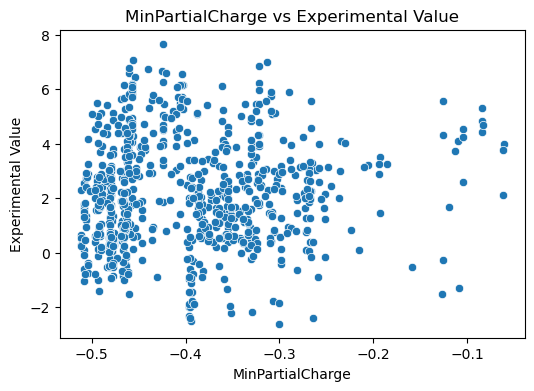

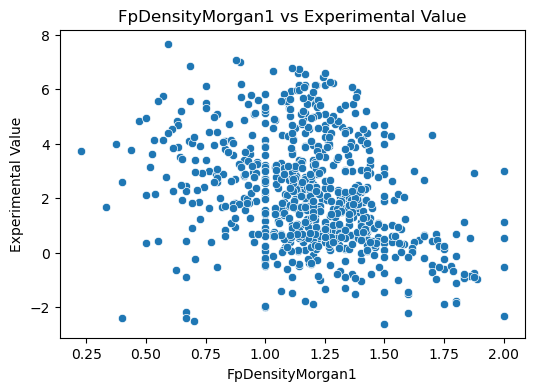

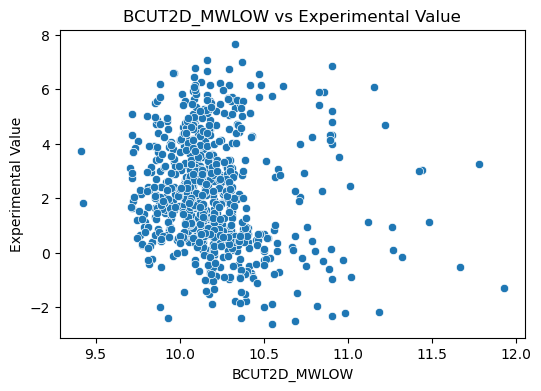

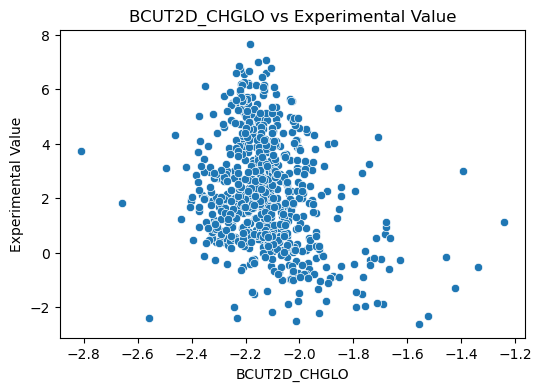

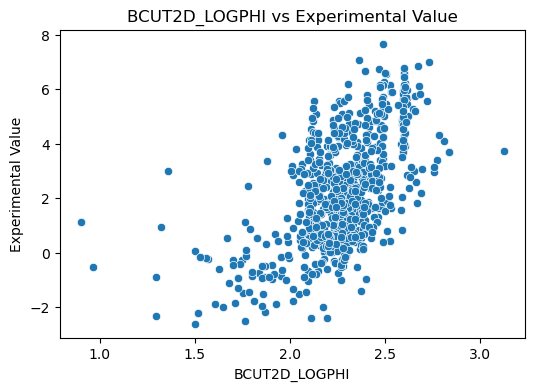

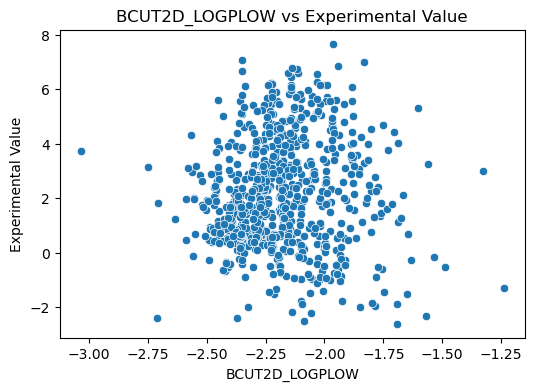

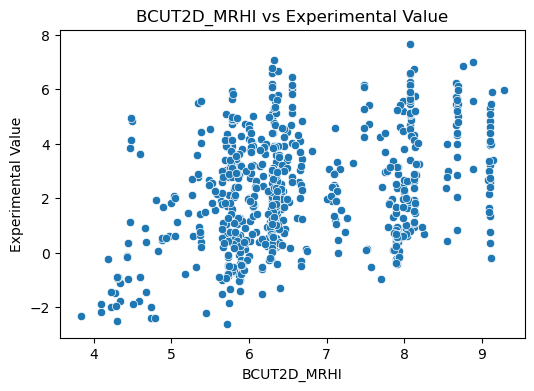

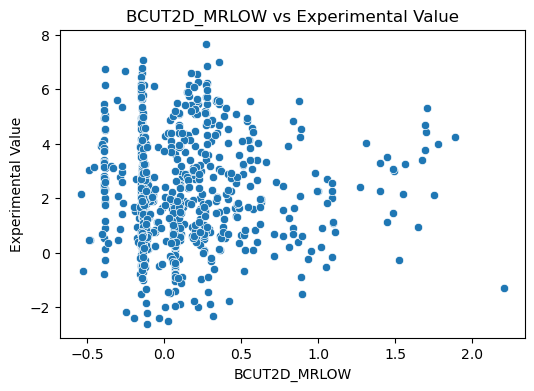

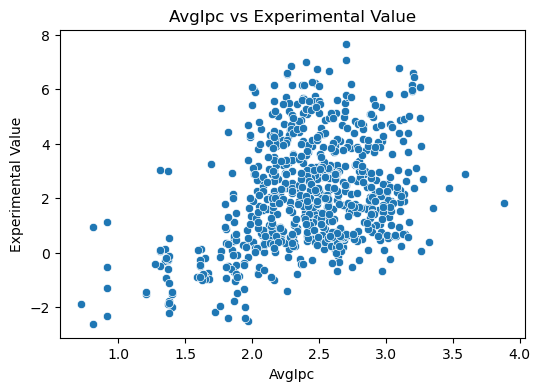

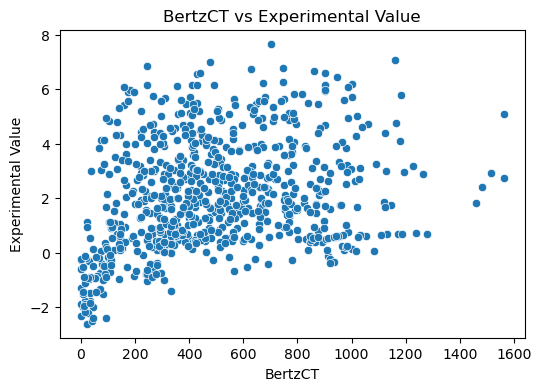

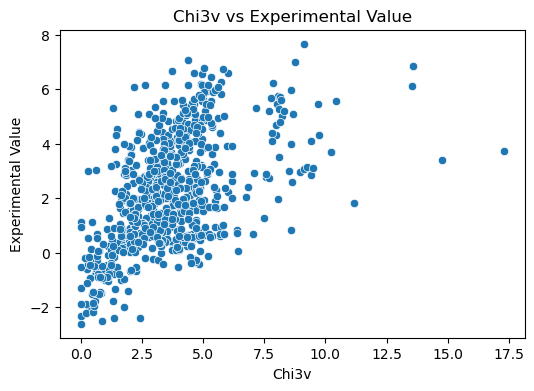

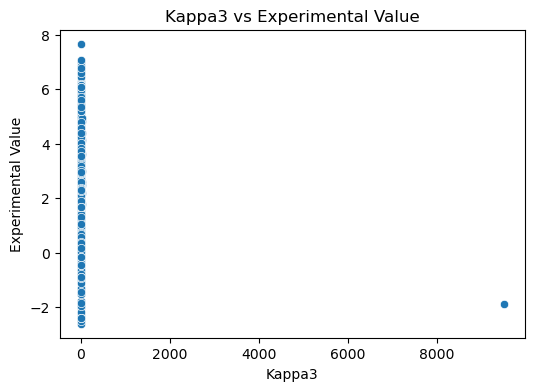

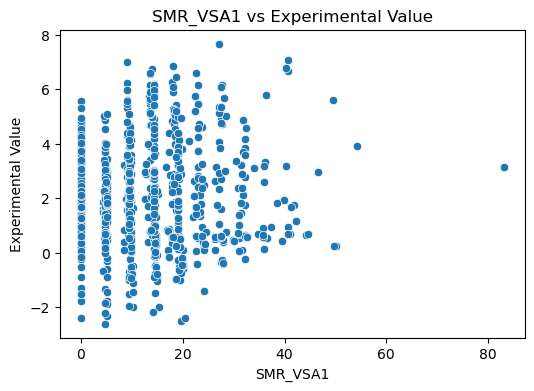

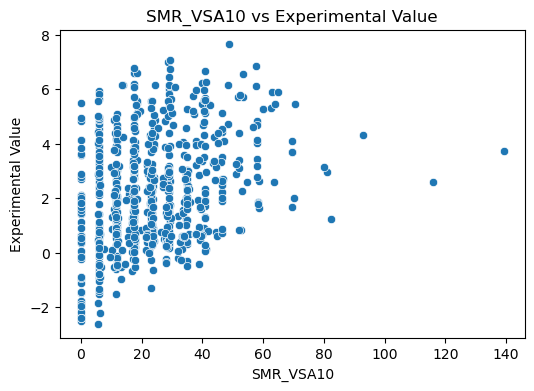

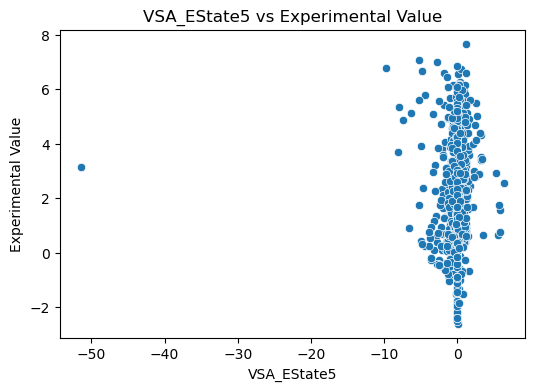

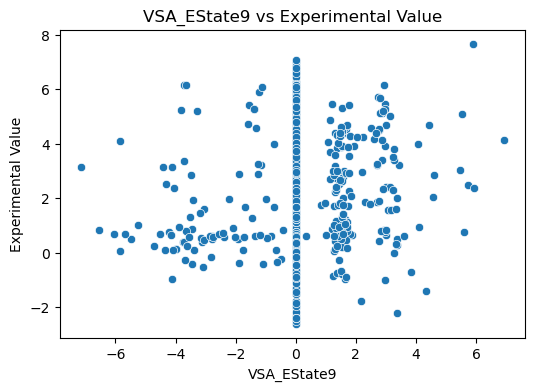

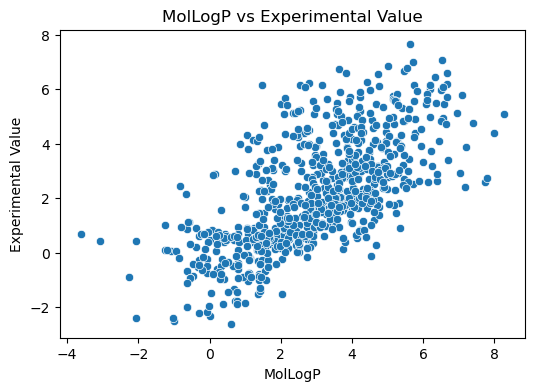

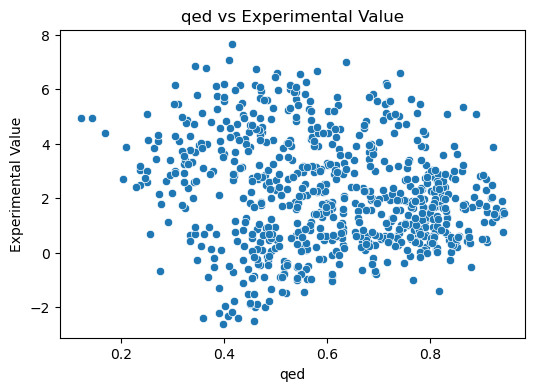

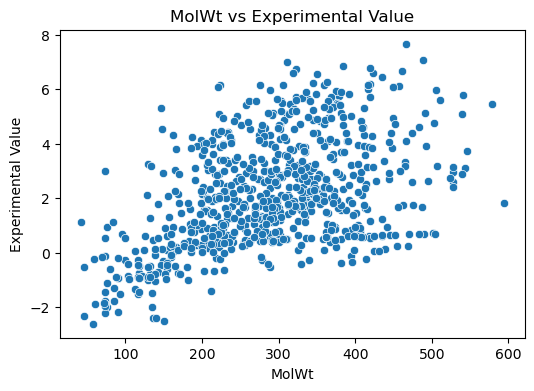

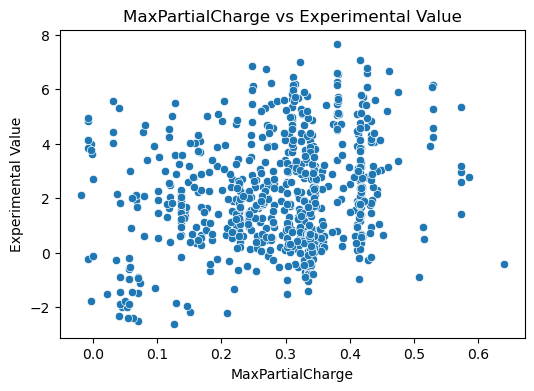

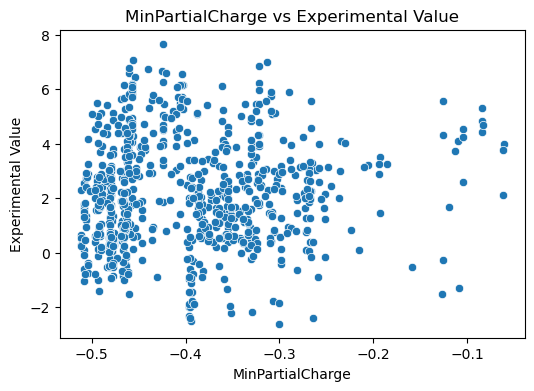

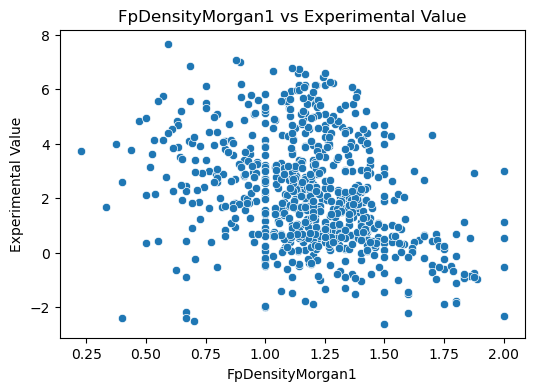

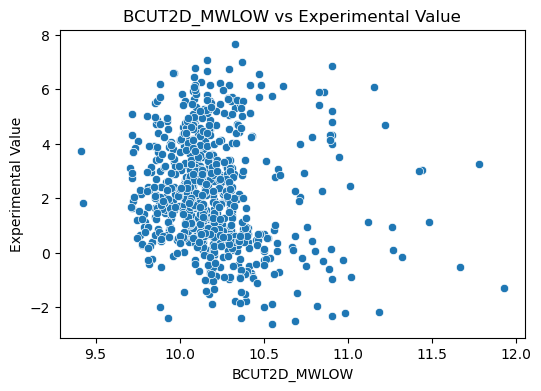

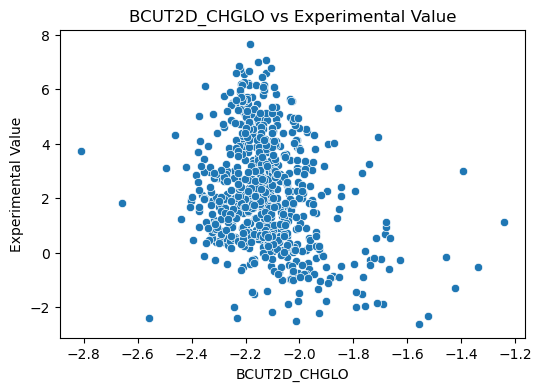

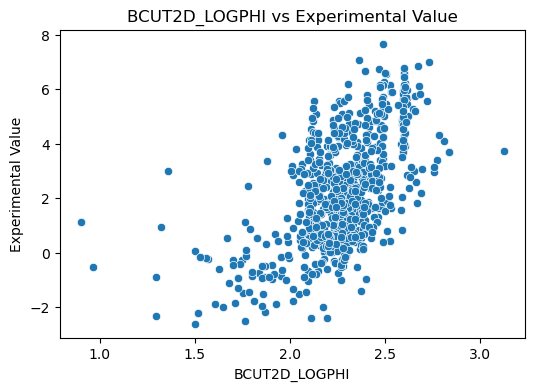

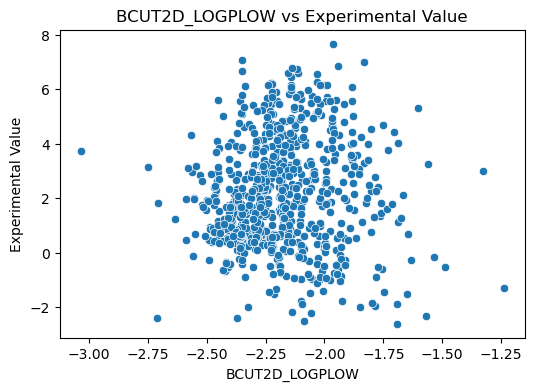

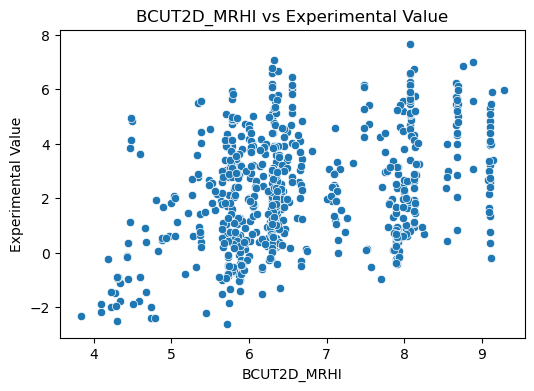

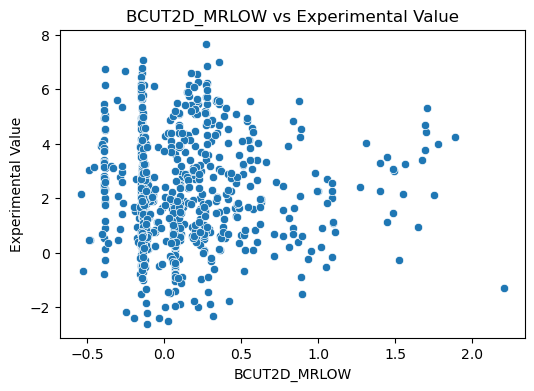

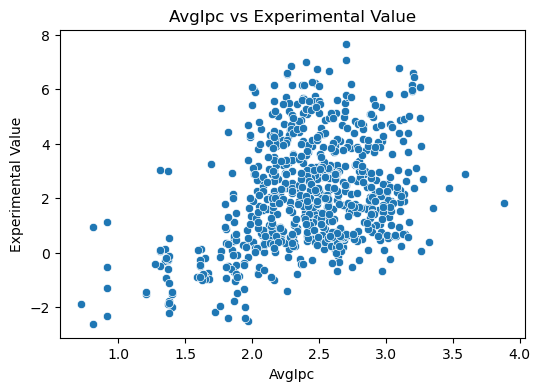

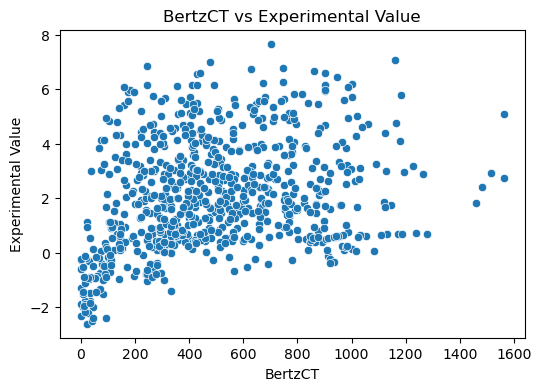

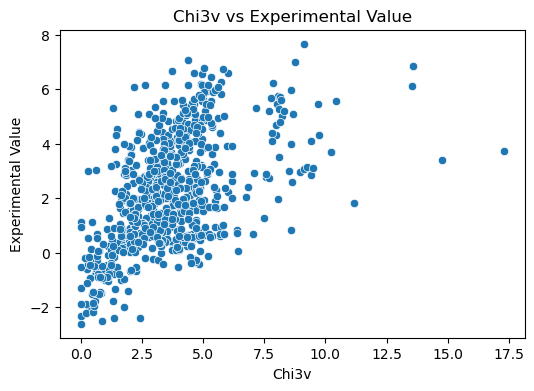

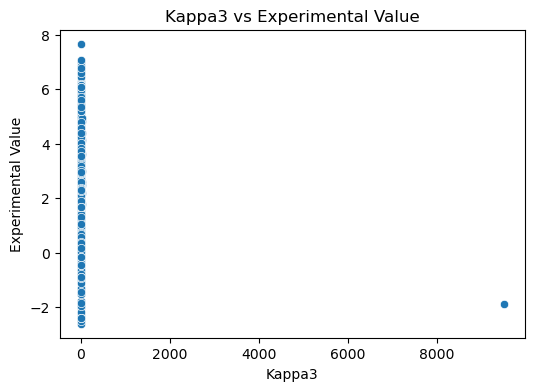

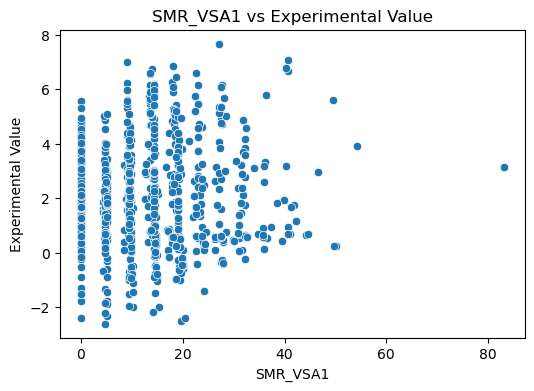

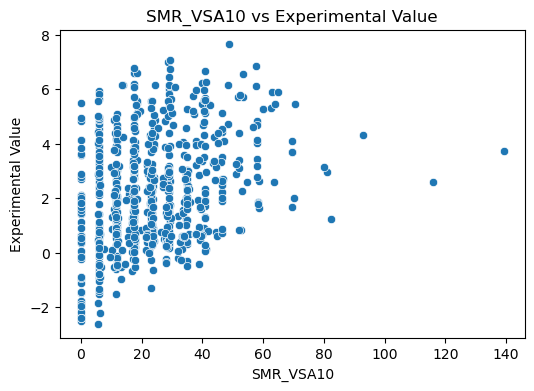

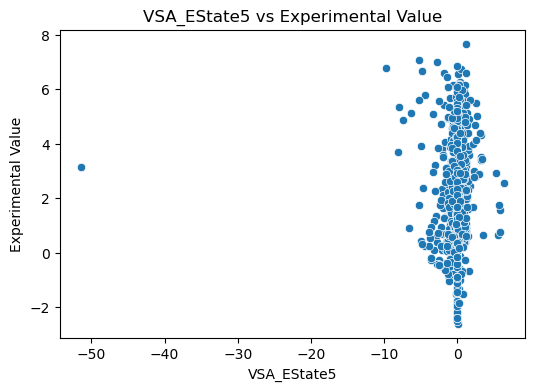

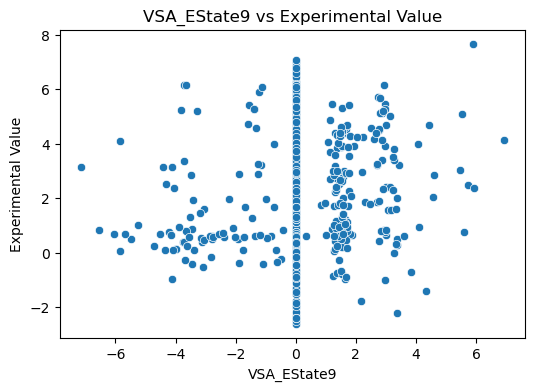

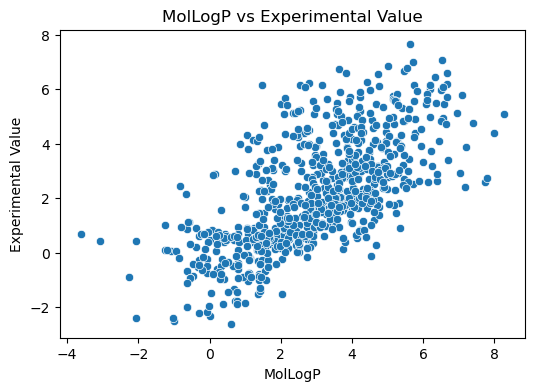

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
import chardet

# -----------------------------
# Step 1: Detect file encoding
# -----------------------------
def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read(10000))  # read first 10k bytes
    return result['encoding']

# File paths
descriptors_file = ("C:/Users/gkjhe/Downloads/700 compunds of pesticides/Molecular_Descriptors_Filtered.xlsx")
target_file = ("C:/Users/gkjhe/Downloads/700 compunds of pesticides/experimental value .xlsx")  

# Detect encoding
desc_encoding = detect_encoding(descriptors_file)
target_encoding = detect_encoding(target_file)

# -----------------------------
# Step 2: Load CSVs with correct encoding
# -----------------------------
X = pd.read_excel(descriptors_file)
y = pd.read_excel(target_file)
y = y.values.ravel()  # flatten if single column

# -----------------------------
# Step 3: RFE to select top 20 descriptors
# -----------------------------
model = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=model, n_features_to_select=20)
rfe.fit(X, y)

top20_descriptors = X.columns[rfe.support_]
print("Top 20 descriptors selected by RFE:")
for i, feature in enumerate(top20_descriptors, start=1):
    print(f"{i}. {feature}")

# -----------------------------
# Step 4: Prepare data for EDA
# -----------------------------
eda_df = X[top20_descriptors].copy()
eda_df['ExperimentalValue'] = y

# -----------------------------
# Step 5: Summary statistics
# -----------------------------
print("\nSummary statistics:")
print(eda_df.describe())

# -----------------------------
# Step 6: Correlation heatmap
# -----------------------------
plt.figure(figsize=(12,10))
corr_matrix = eda_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Top 20 Descriptors + Experimental Value")
plt.show()

# -----------------------------
# Step 7: Distribution plots
# -----------------------------
# Distribution plots
for col in top20_descriptors:
    plt.figure(figsize=(6,4))
    sns.histplot(data=eda_df, x=col, kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

# Scatter plots vs target
for col in top20_descriptors:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=eda_df, x=col, y='ExperimentalValue')
    plt.title(f'{col} vs Experimental Value')
    plt.xlabel(col)
    plt.ylabel('Experimental Value')
    plt.show()


# -----------------------------
# Step 9: Scatter plots vs Experimental Value
# -----------------------------
for col in top20_descriptors:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=eda_df[col], y=eda_df['ExperimentalValue'])
    plt.title(f'{col} vs Experimental Value')
    plt.xlabel(col)
    plt.ylabel('Experimental Value')
    plt.show()


In [5]:
from sklearn.model_selection import train_test_split

# Use only top 20 descriptors
X_top20 = X[top20_descriptors]

# Split the dataset: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_top20, y, test_size=0.2, random_state=42
)

# Optional: check shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (596, 20)
X_test shape: (149, 20)
y_train shape: (596,)
y_test shape: (149,)


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming you already have:
# X -> your full feature DataFrame
# y -> your target variable
# Top20_descriptors -> list of the 20 selected feature names

# Select only top 20 descriptors

X_top20 = X[top20_descriptors]

# Split dataset (optional step)
X_train, X_test, y_train, y_test = train_test_split(
    X_top20, y, test_size=0.2, random_state=42
)

# Combine X and y to save together (optional)
train_data = X_train.copy()
train_data["pEC50"] = y_train

test_data = X_test.copy()
test_data["PEC50"] = y_test

# Save to Excel file
with pd.ExcelWriter("Top20_descriptors_data.xlsx") as writer:
    train_data.to_excel(writer, sheet_name="Train Data", index=False)
    test_data.to_excel(writer, sheet_name="Test Data", index=False)

print("✅ Excel file 'Top20_descriptors_data.xlsx' created successfully!")


✅ Excel file 'Top20_descriptors_data.xlsx' created successfully!


In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# -----------------------------
# 1. Initialize and train Random Forest
# -----------------------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# -----------------------------
# 2. Make predictions
# -----------------------------
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# -----------------------------
# 3. Evaluate model
# -----------------------------
def evaluate_model(y_true, y_pred, dataset_name="Dataset"):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"--- {dataset_name} Evaluation ---")
    print(f"R²   : {r2:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}\n")

# Evaluate on training data
evaluate_model(y_train, y_train_pred, "Training Set")


# Evaluate on testing data
evaluate_model(y_test, y_test_pred, "Test Set")


--- Training Set Evaluation ---
R²   : 0.9571
MAE  : 0.2978
MSE  : 0.1671
RMSE : 0.4088

--- Test Set Evaluation ---
R²   : 0.6682
MAE  : 0.8962
MSE  : 1.3535
RMSE : 1.1634



In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
x_categorical = df.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = df.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values

regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

regressor.fit(x, y)

C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\ensemble\_forest.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [9]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

model = RandomForestRegressor(random_state=42)

# Try different numbers of top features
for k in [10, 15, 20, 25, 30]:
    selector = RFE(model, n_features_to_select=k)
    selector.fit(X, y)
    
    scores = cross_val_score(model, X.iloc[:, selector.support_], y, cv=5, scoring='neg_root_mean_squared_error')
    rmse = -np.mean(scores)
    print(f"Top {k} features → RMSE: {rmse:.3f}")


Top 10 features → RMSE: 1.138
Top 15 features → RMSE: 1.142
Top 20 features → RMSE: 1.130
Top 25 features → RMSE: 1.132
Top 30 features → RMSE: 1.133


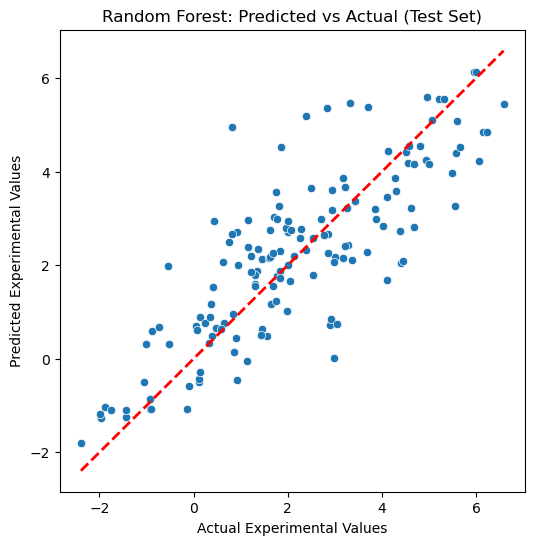

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1. Scatter plot: Predicted vs Actual
# -----------------------------
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # diagonal line
plt.xlabel("Actual Experimental Values")
plt.ylabel("Predicted Experimental Values")
plt.title("Random Forest: Predicted vs Actual (Test Set)")
plt.show()


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Example: Replace with your data loading step
# X, y = ...

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define grid of hyperparameters
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [ 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

# Train the model with best hyperparameters
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'R²: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')


Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1500}
R²: 0.7187
MAE: 0.8349
MSE: 1.1474
RMSE: 1.0712


In [12]:
!pip install lightgbm


In [13]:
import lightgbm as lgb

model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=15,
    num_leaves=100,
    min_data_in_leaf=10,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)
model.fit(X_train, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10784
[LightGBM] [Info] Number of data points in the train set: 596, number of used

LGBMRegressor(bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.01,
              max_depth=15, min_data_in_leaf=10, n_estimators=2000,
              num_leaves=100, random_state=42, reg_alpha=0.1, reg_lambda=0.1)

In [14]:
pip install openpyxl xlrd


Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# 1️⃣ Load your data
df_x = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/Top20_descriptors_data.xlsx")
df_y = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/experimental value .xlsx",engine="openpyxl")
print(df_x.head())
print(df_y.head())


        qed    MolWt  MaxPartialCharge  MinPartialCharge  FpDensityMorgan1  \
0  0.805090  208.261          0.411839         -0.410353          1.400000   
1  0.824047  300.358          0.425706         -0.494522          1.045455   
2  0.890435  310.687          0.325657         -0.307643          0.952381   
3  0.523450  345.377          0.300473         -0.360364          1.000000   
4  0.816031  352.887          0.324788         -0.334860          1.217391   

   BCUT2D_MWLOW  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  \
0     10.157474     -2.156285       2.225979       -2.217121     5.701072   
1     10.050132     -2.145867       2.295500       -2.314567     5.744690   
2     10.160546     -2.075729       2.138516       -2.349138     6.302047   
3     10.157513     -2.229270       2.396630       -2.264486     7.903176   
4      9.955228     -2.272798       2.429111       -2.479930     8.137202   

   ...    AvgIpc     BertzCT     Chi3v    Kappa3   SMR_VSA1  SMR_VSA

In [16]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1️⃣ Load your data
df_x = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/8 molecualr desriptors.xlsx")
df_y = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/experimental value .xlsx",engine="openpyxl")

# Ensure y is a 1D array (LightGBM expects this)
y = y.squeeze()  # Converts DataFrame to Series if needed

# 2️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3️⃣ Base model
model = lgb.LGBMRegressor(random_state=42)

# 4️⃣ Parameter grid
param_grid = {
    'num_leaves': [31, 63, 127, 255],
    'max_depth': [10, 15, 20, -1],
    'learning_rate': [0.01, 0.03, 0.05],
    'n_estimators': [1000, 2000, 3000],
    'min_data_in_leaf': [10, 20, 30, 50],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'subsample_freq': [1, 5, 10],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.5, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# 5️⃣ Randomized Search setup
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,  # Increase for better tuning
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 6️⃣ Run search
search.fit(X_train, y_train)

# 7️⃣ Evaluate best model
print("✅ Best Parameters:", search.best_params_)

best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n📊 Model Performance on Test Set:")
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=TRUE))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10784
[LightGBM] [Info

NameError: name 'TRUE' is not defined

In [16]:
# 1. Import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 2. Load your data (X = descriptors, y = activities)
X = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/8 molecualr desriptors.xlsx")
y = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/experimental value .xlsx")

# 3. Define the base model (Random Forest)
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42
)

# 4. Wrap it in Multi-Target Regressor (for MTR)
mtr_model = MultiOutputRegressor(rf)

# 5. Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
rmse_scores = []

# 6. Perform cross-validation manually
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    mtr_model.fit(X_train, y_train)
    y_pred = mtr_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)

# 7. Display results
print("Average R²:", np.mean(r2_scores))
print("Average RMSE:", np.mean(rmse_scores))


Average R²: 0.6821375351943727
Average RMSE: 1.1151305066583217


In [17]:
print(f"""
📄 QSAR Model Summary
---------------------
Algorithm: Random Forest (Multi-Target)
Cross-Validation: 5-Fold
Average R²: {0.682:.3f}
Average RMSE: {1.115:.3f}

Interpretation:
- The model captures about 68% of variance across targets.
- Typical prediction error is ~1.1 units.
- Performance indicates a robust, generalizable QSAR model suitable for virtual screening or lead prioritization.
""")



📄 QSAR Model Summary
---------------------
Algorithm: Random Forest (Multi-Target)
Cross-Validation: 5-Fold
Average R²: 0.682
Average RMSE: 1.115

Interpretation:
- The model captures about 68% of variance across targets.
- Typical prediction error is ~1.1 units.
- Performance indicates a robust, generalizable QSAR model suitable for virtual screening or lead prioritization.



In [18]:
!pip install xgboost lightgbm -q


In [19]:
# 1. Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# 2. Load your data (X = descriptors, y = activities)
X = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/8 molecualr desriptors.xlsx")
y = pd.read_excel("C:/Users/gkjhe/Downloads/700 compunds of pesticides/experimental value .xlsx")

target_names = y.columns.tolist()

# 3. Define models
models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=600,
        max_depth=30,
        min_samples_split=3,
        min_samples_leaf=1,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=800,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=50,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

# 4. Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 5. Evaluation loop
results = []

for model_name, model in models.items():
    print(f"\n🔬 Evaluating {model_name}...")
    
    mtr = MultiOutputRegressor(model)
    r2_scores, rmse_scores = [], []
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        mtr.fit(X_train, y_train)
        y_pred = mtr.predict(X_test)
        
        r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        r2_scores.append(r2)
        rmse_scores.append(rmse)
    
    avg_r2 = np.mean(r2_scores)
    avg_rmse = np.mean(rmse_scores)
    
    results.append({
        'Model': model_name,
        'Avg R2': avg_r2,
        'Avg RMSE': avg_rmse
    })
    
    print(f"✅ {model_name} → Avg R²: {avg_r2:.3f} | Avg RMSE: {avg_rmse:.3f}")

# 6. Compare all models
results_df = pd.DataFrame(results)
print("\n📊 Model Comparison Summary:")
print(results_df)



🔬 Evaluating Random Forest...
✅ Random Forest → Avg R²: 0.692 | Avg RMSE: 1.098

🔬 Evaluating XGBoost...
✅ XGBoost → Avg R²: 0.692 | Avg RMSE: 1.097

🔬 Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3403
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 19
[LightGBM] [Info] Start training from score 2.151282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

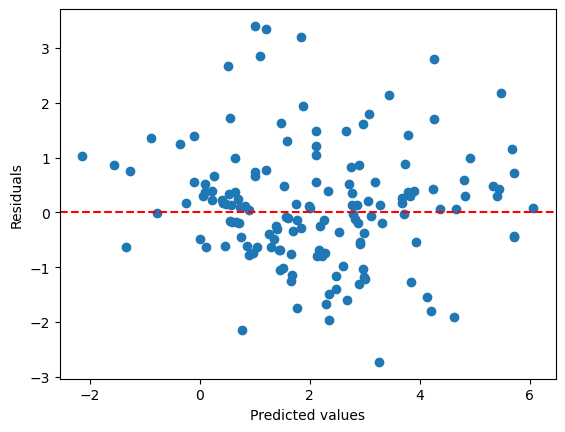

In [20]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()


C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR R2: 0.3174
SVR RMSE: 1.6686


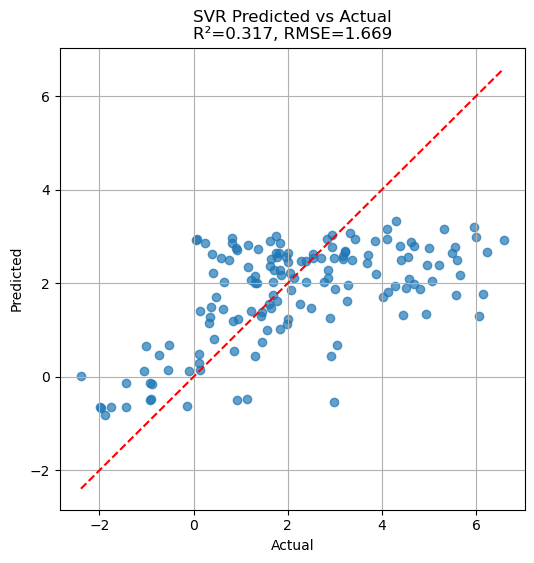

ValueError: Unable to coerce to Series, length must be 1: given 149

In [21]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVR model
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train, y_train)

# Predictions
y_pred = svr.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"SVR R2: {r2:.4f}")
print(f"SVR RMSE: {rmse:.4f}")

# --- Plot 1: Actual vs Predicted ---
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'SVR Predicted vs Actual\nR²={r2:.3f}, RMSE={rmse:.3f}')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.show()

# --- Plot 2: Residual Plot (optional) ---
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='r', linestyle='--')
plt.title("SVR Residual Plot")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

svr_pipeline.fit(X_train, y_train)
y_pred = svr_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Scaled SVR R2: {r2:.4f}, RMSE: {rmse:.4f}")


Scaled SVR R2: 0.6406, RMSE: 1.2107


C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


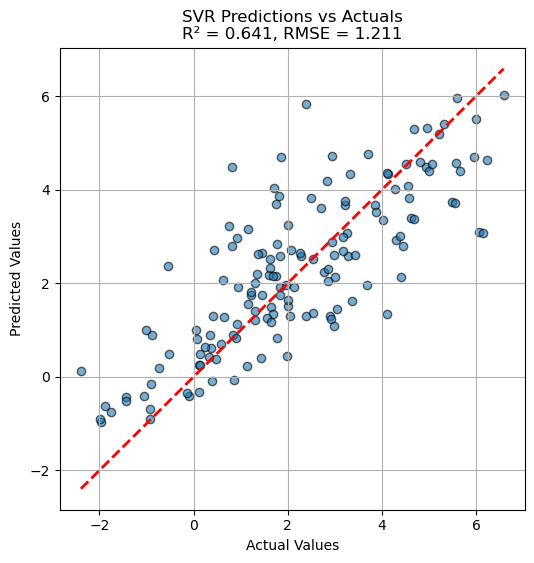

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Your existing code
# svr_pipeline.fit(X_train, y_train)
# y_pred = svr_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'SVR Predictions vs Actuals\nR² = {r2:.3f}, RMSE = {rmse:.3f}')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5]
}

grid_search = GridSearchCV(svr_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)

best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Tuned SVR R2: {r2:.4f}, RMSE: {rmse:.4f}")


Best params: {'svr__C': 10, 'svr__epsilon': 0.5, 'svr__gamma': 0.01}
Best CV R2: 0.6424566185276082
Tuned SVR R2: 0.6273, RMSE: 1.2330


C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warni

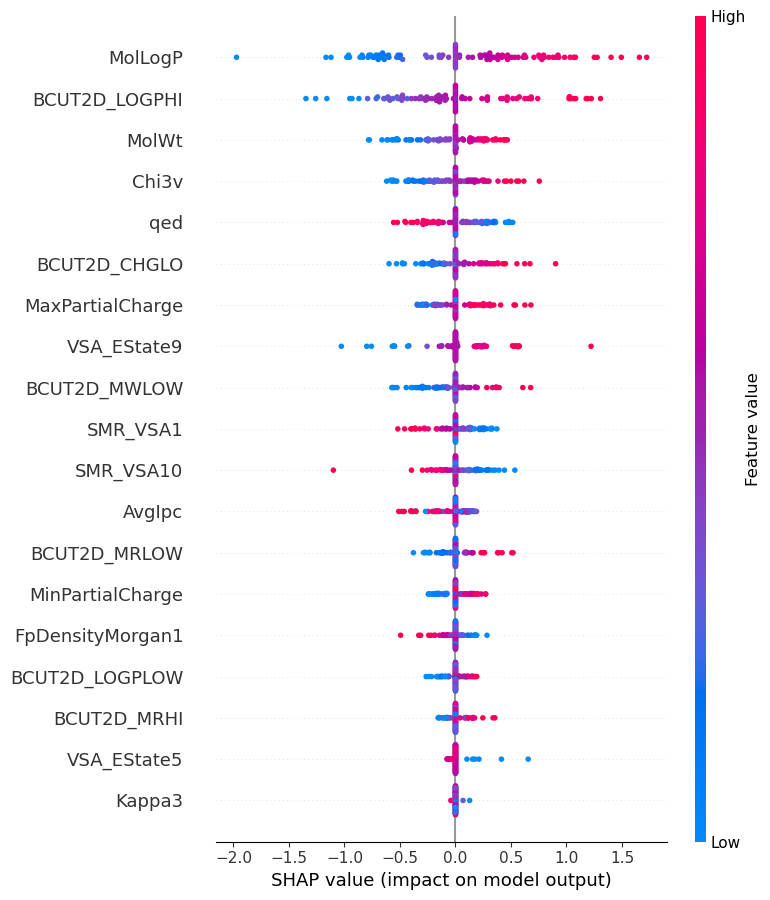

In [25]:
import shap
import numpy as np

# Sample smaller subsets for speed
X_train_sample = shap.sample(X_train, 100, random_state=42)
X_test_sample = shap.sample(X_test, 100, random_state=42)

# Define a wrapper that applies scaling + prediction
def pipeline_predict(X):
    return best_svr.predict(X)

# Use the preprocessed data (SHAP will feed already scaled values if we handle scaling inside the pipeline)
explainer = shap.KernelExplainer(pipeline_predict, X_train_sample)
shap_values = explainer.shap_values(X_test_sample, nsamples=100)

# Plot global summary
shap.summary_plot(shap_values, X_test_sample, feature_names=X.columns)


  0%|          | 0/100 [00:00<?, ?it/s]

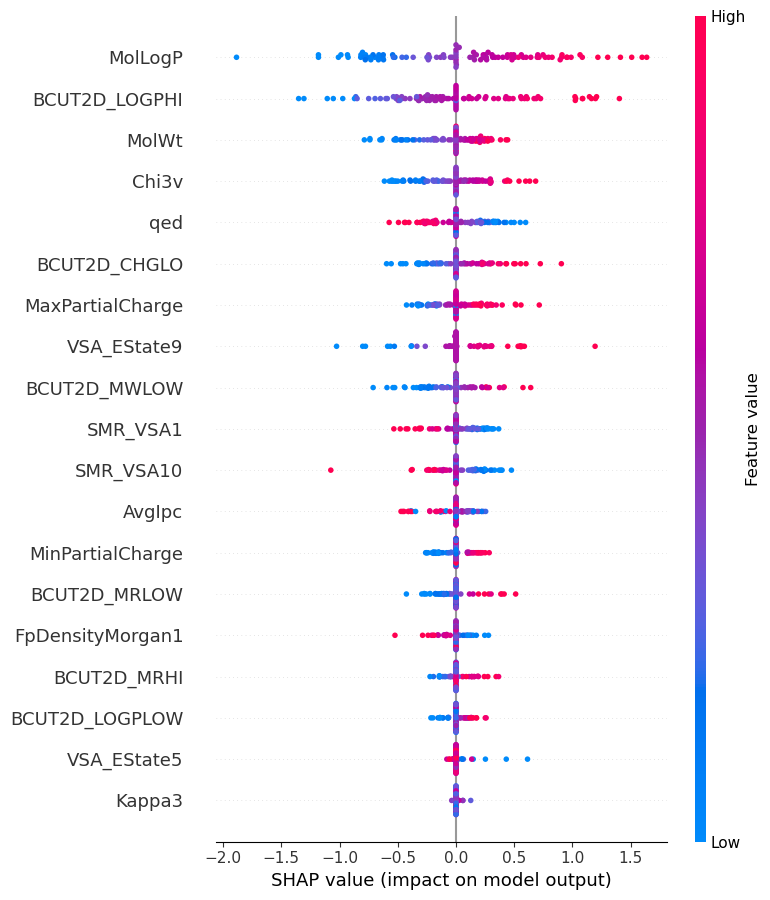

In [26]:
import shap
import numpy as np

# --- 1️⃣  Prepare sampled data for SHAP (small subset = faster)
X_train_sample = shap.sample(X_train, 100, random_state=42)
X_test_sample = shap.sample(X_test, 100, random_state=42)

# --- 2️⃣  Extract the scaler and model from the pipeline
scaler = best_svr.named_steps['scaler']
svr_model = best_svr.named_steps['svr']

# --- 3️⃣  Scale data before passing to SHAP
X_train_scaled = scaler.transform(X_train_sample)
X_test_scaled = scaler.transform(X_test_sample)

# --- 4️⃣  Define a simple prediction wrapper for the SVR model
def svr_predict(X_scaled):
    return svr_model.predict(X_scaled)

# --- 5️⃣  Initialize SHAP explainer
explainer = shap.KernelExplainer(svr_predict, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled, nsamples=100)

# --- 6️⃣  Plot global summary
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)


Best SVR Params: {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__gamma': 'scale'}
R²: 0.655, RMSE: 1.186


C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  0%|          | 0/100 [00:00<?, ?it/s]

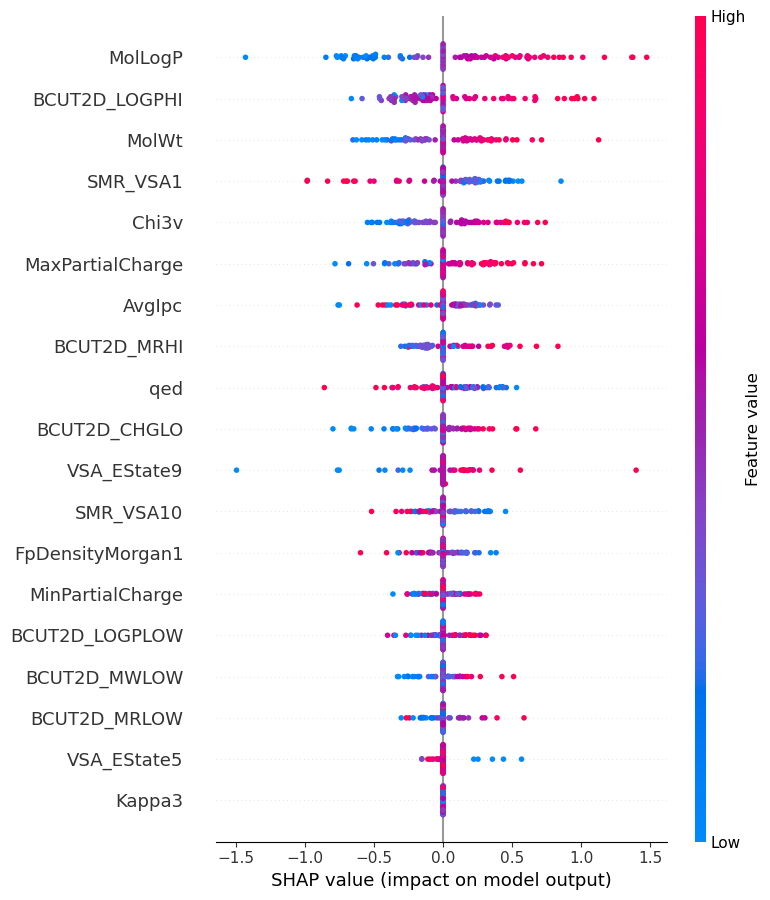

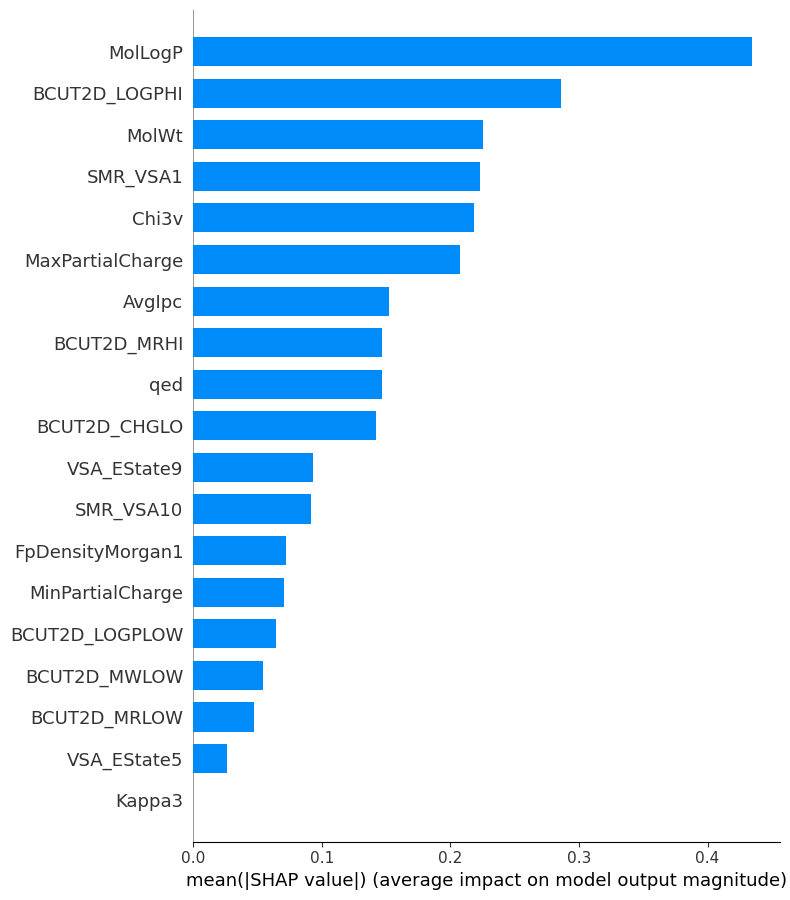

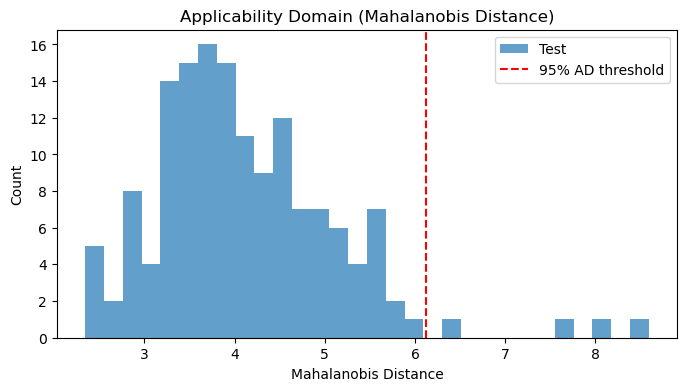

ValueError: Unable to coerce to Series, length must be 1: given 149

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from scipy.spatial import distance

# ============================================================
# 1️⃣ Train/test split (replace X, y with your data)
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ============================================================
# 2️⃣ SVR pipeline with scaling + hyperparameter tuning
# ============================================================
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid = {
    'svr__C': [1, 10, 100],
    'svr__gamma': ['scale', 0.1, 1],
    'svr__epsilon': [0.01, 0.1, 0.2]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)
best_svr = grid.best_estimator_

y_pred = best_svr.predict(X_test)
print(f"Best SVR Params: {grid.best_params_}")
print(f"R²: {r2_score(y_test, y_pred):.3f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# ============================================================
# 3️⃣ SHAP INTERPRETABILITY (bar + summary)
# ============================================================
scaler = best_svr.named_steps['scaler']
svr_model = best_svr.named_steps['svr']

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

explainer = shap.KernelExplainer(svr_model.predict, shap.sample(X_train_scaled, 100, random_state=42))
shap_values = explainer.shap_values(shap.sample(X_test_scaled, 100, random_state=42))

# --- Summary Plot (beeswarm) ---
shap.summary_plot(shap_values, shap.sample(X_test_scaled, 100, random_state=42), feature_names=X.columns)

# --- Bar Plot (mean absolute SHAP values) ---
shap.summary_plot(shap_values, shap.sample(X_test_scaled, 100, random_state=42), feature_names=X.columns, plot_type="bar")

# ============================================================
# 4️⃣ APPLICABILITY DOMAIN (Mahalanobis distance + leverage plot)
# ============================================================
# Compute Mahalanobis distance for AD
cov = np.cov(X_train_scaled, rowvar=False)
inv_cov = np.linalg.inv(cov)
mean_vec = X_train_scaled.mean(axis=0)

def mahalanobis_dist(X_scaled):
    return np.array([distance.mahalanobis(x, mean_vec, inv_cov) for x in X_scaled])

train_maha = mahalanobis_dist(X_train_scaled)
test_maha = mahalanobis_dist(X_test_scaled)
threshold = np.percentile(train_maha, 95)  # AD threshold

# --- AD Histogram ---
plt.figure(figsize=(8, 4))
plt.hist(test_maha, bins=30, alpha=0.7, label='Test')
plt.axvline(threshold, color='r', linestyle='--', label='95% AD threshold')
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Count")
plt.title("Applicability Domain (Mahalanobis Distance)")
plt.legend()
plt.show()

# --- Leverage Plot (distance vs residuals) ---
residuals = y_test - y_pred
plt.figure(figsize=(7, 5))
plt.scatter(test_maha, residuals, alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', label='AD limit (95%)')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Residuals")
plt.title("Applicability Domain - Leverage Plot")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor   # make sure lightgbm is installed

# --- Cross-Validation Setup ---
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "SVM": SVR(),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=-1,
        random_state=42
    )
}

# --- Evaluate each model ---
for name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=kf)
    Q2 = r2_score(y, y_pred)
    print(f"{name} Q² = {Q2:.4f}")


C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

RandomForest Q² = 0.6816


C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

SVM Q² = 0.2646
XGBoost Q² = 0.6947
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3403
[LightGBM] [Info] Number of data points in the train set: 596, number of used features: 19
[LightGBM] [Info] Start training from score 2.151282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [29]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# -------------------------
# Example: Split dataset
# -------------------------
# X, y are your features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------
# SVM pipeline with scaling
# -------------------------
model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVR(kernel='rbf', C=10, gamma=0.01, epsilon=0.1))  # example params
])

# -------------------------
# Cross-validated predictions (for Q²)
# -------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_cv_pred = cross_val_predict(model, X_train, y_train, cv=cv)

# -------------------------
# Fit model on full training set
# -------------------------
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

# -------------------------
# Function to calculate QSAR metrics
# -------------------------
def qsar_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    q2 = r2  # For CV predictions, Q² is essentially R² of CV
    return {'R²': r2, 'Q²': q2, 'RMSE': rmse, 'MAE': mae}

# -------------------------
# Metrics for training (CV) and test
# -------------------------
train_metrics = qsar_metrics(y_train, y_cv_pred)
test_metrics = qsar_metrics(y_test, y_test_pred)

print("Training (CV) metrics:", train_metrics)
print("Test metrics:", test_metrics)


C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

Training (CV) metrics: {'R²': 0.6331388246100699, 'Q²': 0.6331388246100699, 'RMSE': np.float64(1.1953331536653284), 'MAE': 0.914708194875919}
Test metrics: {'R²': 0.6244857241395667, 'Q²': 0.6244857241395667, 'RMSE': np.float64(1.237616680135143), 'MAE': 0.9418517727370598}


C:\Users\gkjhe\Downloads\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [46]:
y_pred_rf      = results["RandomForest"]["test_pred"]
y_pred_svm     = results["SVR"]["test_pred"]
y_pred_xgb     = results["XGBoost"]["test_pred"]
y_pred_lgbm    = results["LightGBM"]["test_pred"]


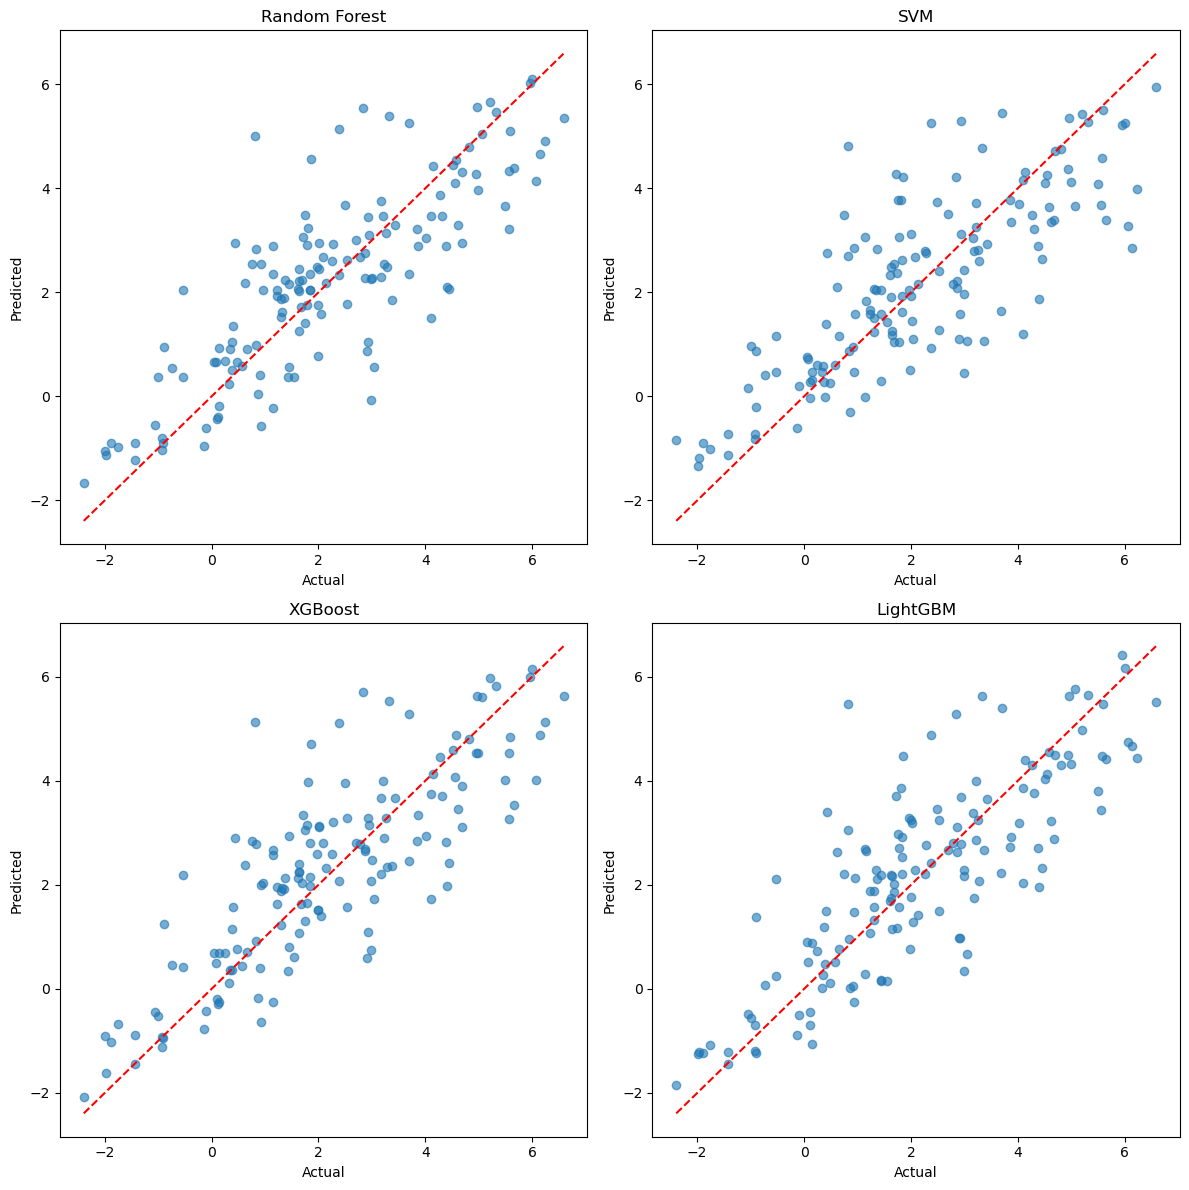

In [47]:
import matplotlib.pyplot as plt
import numpy as np

predictions = {
    "Random Forest": y_pred_rf,
    "SVM": y_pred_svm,
    "XGBoost": y_pred_xgb,
    "LightGBM": y_pred_lgbm
}

y_test_plot = np.ravel(y_test)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for ax, (name, y_pred) in zip(axes.flatten(), predictions.items()):
    y_pred = np.ravel(y_pred)

    ax.scatter(y_test_plot, y_pred, alpha=0.6)

    # Identity line
    mn = min(y_test_plot.min(), y_pred.min())
    mx = max(y_test_plot.max(), y_pred.max())
    ax.plot([mn, mx], [mn, mx], 'r--')

    ax.set_title(name)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")

plt.tight_layout()
plt.show()
